In [19]:
import os, random
import numpy as np
import scanpy as sc
import pandas as pd
import anndata
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


In [20]:
from tensorflow.python.framework.ops import enable_eager_execution, disable_eager_execution

In [21]:
disable_eager_execution()

# Load Data

In [22]:
noise_file = "sim_g2_dropout_5"

obs_label_column = "Group"

adata = sc.read_h5ad(f"C:\\Users\\gmaho\\Desktop\\ai_masters_thesis\\simulated_datasets\\{noise_file}.h5ad")

In [23]:
sim_raw = adata

y = np.array(adata.obs[obs_label_column])

sim_true = sc.AnnData(adata.layers["TrueCounts"],obs=pd.DataFrame(y, columns=[obs_label_column]))

D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [24]:
sc.pp.filter_genes(sim_raw, min_counts=1)

sim_true

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_total(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

sim_true_norm = sim_true.copy()
sc.pp.normalize_total(sim_true_norm)
sc.pp.log1p(sim_true_norm)
sc.pp.pca(sim_true_norm)

# print(dropout_gt[:10, :10])
print(sim_raw)
print(sim_true)

AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'X_name'
    obsm: 'UMAP'
    layers: 'BCV', 'BaseCellMeans', 'BatchCellMeans', 'CellMeans', 'DropProb', 'Dropout', 'TrueCounts', 'logcounts'
AnnData object with n_obs × n_vars = 2000 × 200
    obs: 'Group'


# Denoise Simulated Data

In [25]:
def run_prep(adata,
        mode='denoise',
        hidden_size=(64, 32, 64), 
        hidden_dropout=0.,
        batchnorm=True,
        activation='relu',
        init='glorot_uniform',
        epochs=300, 
        reduce_lr=10,
        early_stop=20,
        batch_size=32,
        optimizer='RMSprop',
        learning_rate=None,
        random_state=0,
        threads=None,
        verbose=False,
        ):
    

    assert isinstance(adata, anndata.AnnData), 'adata must be an AnnData instance'
    assert mode in ('denoise', 'latent'), '%s is not a valid mode.' % mode

    # set seed for reproducibility
    random.seed(random_state)
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # check for zero genes
    nonzero_genes, _ = sc.pp.filter_genes(adata.X, min_counts=1)

    adata.raw = adata.copy()

    sc.pp.normalize_total(adata, key_added="n_counts")
    adata.obs["sf"] = adata.obs.n_counts / np.median(adata.obs.n_counts)

    sc.pp.scale(adata)

    input_size = output_size = adata.n_vars

    network_keywords = {
                    'input_size': input_size,
                    'output_size': output_size,
                    'hidden_size': hidden_size,
                    'hidden_dropout': hidden_dropout,
                    'batchnorm': batchnorm,
                    'activation': activation,
                    'init': init
                    }

    

    # ------------------------------------------------
    training_keywords = {
                     'epochs': epochs,
                     'reduce_lr': reduce_lr,
                     'early_stop': early_stop,
                     'batch_size': batch_size,
                     'optimizer': optimizer,
                     'verbose': verbose,
                     'threads': threads,
                     'learning_rate': learning_rate
                     }
    #-----------------------------------------------------------------------
    # adata.obs['split'] = 'train'

    # training_data = adata[adata.obs.split == 'train']

    return adata, network_keywords, training_keywords

In [26]:
adata, network_keywords, training_keywords = run_prep(sim_raw)

In [27]:
network_keywords

{'input_size': 195,
 'output_size': 195,
 'hidden_size': (64, 32, 64),
 'hidden_dropout': 0.0,
 'batchnorm': True,
 'activation': 'relu',
 'init': 'glorot_uniform'}

# Building a basic AE model

## Imports

In [28]:
import numpy as np
import scanpy as sc

import keras
from keras.layers import Input, Dense, Activation, BatchNormalization, Lambda, Layer
from keras.models import Model
from keras.losses import MeanSquaredError

import tensorflow as tf

In [29]:
def _nan_to_infinite(x):
    return tf.where(tf.math.is_nan(x), tf.zeros_like(x)+np.inf, x)

Multiply = Lambda(lambda l: l[0]*tf.reshape(l[1], (-1,1)))
MeanActivation = lambda x: tf.clip_by_value(tf.math.exp(x), 1e-5, 1e6)
VarActivation = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

class SliceLayer(Layer):
    def __init__(self, index, **kwargs):
        self.index = index
        super().__init__(**kwargs)

    def build(self, input_shape):
        if not isinstance(input_shape, list):
            raise ValueError('Input should be a list')

        super().build(input_shape)

    def call(self, x):
        assert isinstance(x, list), 'SliceLayer input is not a list'
        return x[self.index]

    def compute_output_shape(self, input_shape):
        return input_shape[self.index]

# Negative Binomial Loss Function attempt
class NbLoss(object):
    def __init__(self, theta=None, scope="nb-loss/",
                 scale=1.0):
        
        # epsilon present for stability
        self.epsilon = 1e-10
        self.scale = scale
        self.theta = theta
        self.scope = scope

    def loss(self, y_true, y_pred, mean=True):
        scale = self.scale
        epsilon = self.epsilon

        with tf.name_scope(self.scope):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale

            theta = tf.minimum(self.theta, 1e6)

            term1 = tf.math.lgamma(theta+epsilon) + tf.math.lgamma(y_true+1.0) - tf.math.lgamma(y_true+theta+epsilon)
            term2 = (theta+y_true) * tf.math.log(1.0 + (y_pred/(theta+epsilon))) + (y_true * (tf.math.log(theta+epsilon) - tf.math.log(y_pred+epsilon)))

            final = term1 + term2

            final = _nan_to_infinite(final)

            if mean:
                final = tf.reduce_mean(final)


        return final

# Zero inflated Negative Binomial Loss Function
class ZiNbLoss(NbLoss):
    def __init__(self, pmw, lambda_=0.0, scope="zinb-loss", **kwargs):
        super().__init__(scope=scope, **kwargs)
        self.pmw = pmw
        self.lambda_ = lambda_

    def loss(self, y_true, y_pred, mean=True):
        scale = self.scale
        epsilon = self.epsilon

        with tf.name_scope(self.scope):
            nb_case = super().loss(y_true, y_pred, mean=False) - tf.math.log(1.0-self.pmw+epsilon)

            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32) * scale
            theta = tf.minimum(self.theta, 1e6)

            zero_nb = tf.pow(theta/(theta+y_pred+epsilon), theta)
            zero_case = -tf.math.log(self.pmw + ((1.0-self.pmw)*zero_nb)+epsilon)
            result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
            r = self.lambda_*tf.square(self.pmw)
            result += r

 
            result = tf.reduce_mean(result)

            result = _nan_to_infinite(result)

        return result

In [30]:
# Create the basic Autoencoder
def create_autoencoder(loss_type="mse"):
    # Step 1, defining the autoencoder
    input = Input(shape=(network_keywords["input_size"],), name='counts')
    sf = Input(shape=(1,), name='sf')

    x = Dense(64, activation=None, kernel_initializer=network_keywords["init"], name="encoder0")(input)

    x = BatchNormalization(center=True, scale=False)(x)

    x = Activation(network_keywords["activation"], name="relu_encoder0")(x)

    x = Dense(32, activation=None, kernel_initializer=network_keywords["init"], name="latent0")(x)

    x = BatchNormalization(center=True, scale=False)(x)

    x = Activation(network_keywords["activation"], name="relu_latent0")(x)

    x = Dense(64, activation=None, kernel_initializer=network_keywords["init"], name="decoder0")(x)

    x = BatchNormalization(center=True, scale=False)(x)

    x = Activation(network_keywords["activation"], name="relu_decoder0")(x)

    if loss_type == "mse":
        mean = Dense(network_keywords["input_size"], kernel_initializer=network_keywords["init"],
                        name='mean')(x)

        output = Multiply([mean, sf])

        return keras.Model(inputs=[input,sf], outputs=output, name="mse_net"), None

    elif loss_type == "nb":
        var = Dense(network_keywords["input_size"], activation=VarActivation,
                           kernel_initializer=network_keywords["init"],
                           name='variance')(x)

        mean = Dense(network_keywords["input_size"], activation=MeanActivation, 
                     kernel_initializer=network_keywords["init"],
                       name='mean')(x)
        
        output = Multiply([mean, sf])
        output = SliceLayer(0, name='slice')([output, var])

        nb = NbLoss(theta=var)
        loss = nb.loss

        return keras.Model(inputs=[input, sf], outputs=output, name="nb_net"), loss
    
    elif loss_type == "zinb":
        # pmw = point mass weight
        pmw = Dense(network_keywords["input_size"], activation='sigmoid', kernel_initializer=network_keywords["init"],
                       name='pi')(x)
        
        var = Dense(network_keywords["input_size"], activation=VarActivation,
                           kernel_initializer=network_keywords["init"],
                           name='variance')(x)

        mean = Dense(network_keywords["input_size"], activation=MeanActivation, kernel_initializer=network_keywords["init"],
                       name='mean')(x)
        
        output = Multiply([mean, sf])
        output = SliceLayer(0, name='slice')([output, var, pmw])

        zinb = ZiNbLoss(pmw, theta=var, lambda_=0)
        loss = zinb.loss

        return keras.Model(inputs=[input, sf], outputs=output, name="zinb_net"), loss

In [31]:
def run(loss_type="zinb"): # loss_type can be mse, nb, zinb
    autoencoder, loss_fn = create_autoencoder(loss_type=loss_type)
    
    if not loss_fn and loss_type == "mse":
        loss_fn = MeanSquaredError()

    autoencoder.compile(
        optimizer=keras.optimizers.RMSprop(lr=1e-3, clipvalue=5),
        loss=loss_fn,) #loss_fn
    
    input_data = {'counts': adata.X, 'sf': adata.obs.sf}
    output_data = adata.raw.X
    
    verbose=False
    lr_patience=10
    es_patience=15
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=lr_patience, verbose=verbose), EarlyStopping(monitor='val_loss', patience=es_patience, verbose=verbose)]
    autoencoder.fit(input_data, output_data, batch_size=32, epochs=300, validation_split=0.1, callbacks=callbacks)
    
    result = autoencoder.predict({'counts': adata.X, 'sf': adata.obs.sf})
    
    denoised_adata = sc.AnnData(result,obs=pd.DataFrame(y, columns=[obs_label_column]))
    
    denoised_adata_norm = denoised_adata.copy()
    
    sc.pp.normalize_total(denoised_adata_norm)
    sc.pp.log1p(denoised_adata_norm)
    
    if loss_type == "mse":
        denoised_adata_norm.X = np.nan_to_num(denoised_adata_norm.X, nan=0.1, posinf=0, neginf=0)
        
    return autoencoder, denoised_adata_norm

D:\Program Files\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train on 1800 samples, validate on 200 samples
Epoch 1/300
1472/1800 [=======================>......] - ETA: 0s - loss: 58.2542

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1800/1800 [==============================] - 2s 918us/sample - loss: 51.3833 - val_loss: 55.1386 - lr: 0.0010
Epoch 2/300
1800/1800 [==============================] - 0s 76us/sample - loss: 9.0838 - val_loss: 18.2393 - lr: 0.0010
Epoch 3/300
1800/1800 [==============================] - 0s 76us/sample - loss: 4.0588 - val_loss: 5.4969 - lr: 0.0010
Epoch 4/300
1800/1800 [==============================] - 0s 79us/sample - loss: 3.4281 - val_loss: 3.5660 - lr: 0.0010
Epoch 5/300
1800/1800 [==============================] - 0s 78us/sample - loss: 3.2375 - val_loss: 3.2381 - lr: 0.0010
Epoch 6/300
1800/1800 [==============================] - 0s 75us/sample - loss: 3.1214 - val_loss: 3.1232 - lr: 0.0010
Epoch 7/300
1800/1800 [==============================] - 0s 77us/sample - loss: 2.9976 - val_loss: 2.9973 - lr: 0.0010
Epoch 8/300
1800/1800 [==============================] - 0s 76us/sample - loss: 2.8644 - val_loss: 2.8838 - lr: 0.0010
Epoch 9/300
1800/1800 [==============================] -

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Program Files\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Denoised(ZINB)'}, xlabel='PC1', ylabel='PC2'>

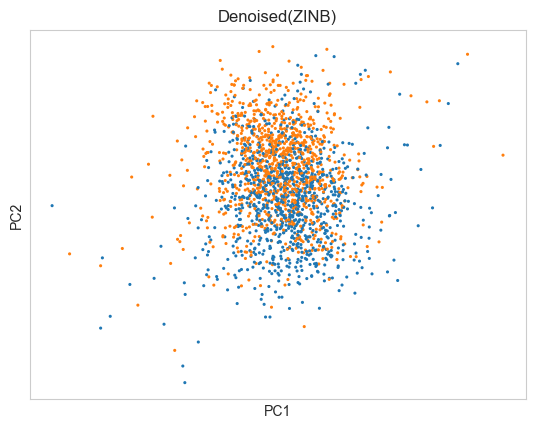

In [32]:
autoencoder, denoised_adata_norm = run(loss_type="zinb")

sc.pp.pca(denoised_adata_norm)
    
sc.pl.pca_scatter(denoised_adata_norm, color='Group', size=20, title="Denoised(ZINB)", show=False, legend_loc='none')

In [33]:
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:

# Generate silhouette scores barplot
d = {"No Dropout": [], "Dropout": [],"ZINB": [], "NB": [], "MSE": [], }
# sim_raw_norm = sim_raw.copy()

d["No Dropout"].append(silhouette_score(sim_true_norm.obsm['X_pca'][:, :2], 
                 sim_true_norm.obs.Group))

d["Dropout"].append(silhouette_score(sim_raw_norm.obsm['X_pca'][:, :2], 
                 sim_raw_norm.obs.Group))

for i in range(0, 1):    
    ae, zinb_r = run(loss_type="zinb")
    
    sc.pp.pca(zinb_r)
    
    d["ZINB"].append(silhouette_score(zinb_r.obsm['X_pca'][:, :2], 
                 zinb_r.obs.Group))
    
    ae, nb_r = run(loss_type="nb")
        
    sc.pp.pca(nb_r)
    
    d["NB"].append(silhouette_score(nb_r.obsm['X_pca'][:, :2], 
                 nb_r.obs.Group))
    
    ae, mse_r = run(loss_type="mse")
    
    sc.pp.pca(mse_r)
    
    d["MSE"].append(silhouette_score(mse_r.obsm['X_pca'][:, :2], 
                 nb_r.obs.Group))

D:\Program Files\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train on 1800 samples, validate on 200 samples
Epoch 1/300
1536/1800 [========================>.....] - ETA: 0s - loss: 62.5041

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1800/1800 [==============================] - 2s 886us/sample - loss: 56.5771 - val_loss: 55.2907 - lr: 0.0010
Epoch 2/300
1800/1800 [==============================] - 0s 76us/sample - loss: 9.8799 - val_loss: 18.2907 - lr: 0.0010
Epoch 3/300
1800/1800 [==============================] - 0s 75us/sample - loss: 4.1544 - val_loss: 5.5292 - lr: 0.0010
Epoch 4/300
1800/1800 [==============================] - 0s 73us/sample - loss: 3.4497 - val_loss: 3.5981 - lr: 0.0010
Epoch 5/300
1800/1800 [==============================] - 0s 78us/sample - loss: 3.2453 - val_loss: 3.2362 - lr: 0.0010
Epoch 6/300
1800/1800 [==============================] - 0s 77us/sample - loss: 3.1232 - val_loss: 3.0884 - lr: 0.0010
Epoch 7/300
1800/1800 [==============================] - 0s 73us/sample - loss: 3.0008 - val_loss: 3.0001 - lr: 0.0010
Epoch 8/300
1800/1800 [==============================] - 0s 77us/sample - loss: 2.8630 - val_loss: 2.8833 - lr: 0.0010
Epoch 9/300
1800/1800 [==============================] -

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Program Files\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train on 1800 samples, validate on 200 samples
Epoch 1/300
1632/1800 [==========================>...] - ETA: 0s - loss: 55.5457

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1800/1800 [==============================] - 2s 1ms/sample - loss: 52.2452 - val_loss: 51.1395 - lr: 0.0010
Epoch 2/300
1800/1800 [==============================] - 0s 73us/sample - loss: 9.1430 - val_loss: 18.3240 - lr: 0.0010
Epoch 3/300
1800/1800 [==============================] - 0s 70us/sample - loss: 4.0675 - val_loss: 5.7192 - lr: 0.0010
Epoch 4/300
1800/1800 [==============================] - 0s 73us/sample - loss: 3.4407 - val_loss: 3.6405 - lr: 0.0010
Epoch 5/300
1800/1800 [==============================] - 0s 69us/sample - loss: 3.2622 - val_loss: 3.3090 - lr: 0.0010
Epoch 6/300
1800/1800 [==============================] - 0s 70us/sample - loss: 3.1770 - val_loss: 3.1866 - lr: 0.0010
Epoch 7/300
1800/1800 [==============================] - 0s 72us/sample - loss: 3.1433 - val_loss: 3.1500 - lr: 0.0010
Epoch 8/300
1800/1800 [==============================] - 0s 71us/sample - loss: 3.1280 - val_loss: 3.1236 - lr: 0.0010
Epoch 9/300
1800/1800 [==============================] - 0

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Program Files\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train on 1800 samples, validate on 200 samples
Epoch 1/300
1376/1800 [=====================>........] - ETA: 0s - loss: 853910.4128  

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1800/1800 [==============================] - 2s 968us/sample - loss: 841681.9294 - val_loss: 803626.6450 - lr: 0.0010
Epoch 2/300
1800/1800 [==============================] - 0s 43us/sample - loss: 840602.6208 - val_loss: 803044.2900 - lr: 0.0010
Epoch 3/300
1800/1800 [==============================] - 0s 45us/sample - loss: 839226.3267 - val_loss: 802057.0100 - lr: 0.0010
Epoch 4/300
1800/1800 [==============================] - 0s 44us/sample - loss: 837525.8169 - val_loss: 800648.7650 - lr: 0.0010
Epoch 5/300
1800/1800 [==============================] - 0s 41us/sample - loss: 835582.2967 - val_loss: 798542.9950 - lr: 0.0010
Epoch 6/300
1800/1800 [==============================] - 0s 41us/sample - loss: 833455.1017 - val_loss: 796618.2375 - lr: 0.0010
Epoch 7/300
1800/1800 [==============================] - 0s 41us/sample - loss: 831222.7836 - val_loss: 794791.1625 - lr: 0.0010
Epoch 8/300
1800/1800 [==============================] - 0s 45us/sample - loss: 828776.8028 - val_loss: 7929

D:\Program Files\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
D:\Program Files\Python311\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Program Files\Python311\Lib\site-packages\scanpy\preprocessing\_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [35]:
df = pd.DataFrame([(k, v) for k, values in d.items() for v in values], columns=['Category', 'Silhouette Score'])

# Display the DataFrame
df

,Category,Silhouette Score
0,No Dropout,0.603868
1,Dropout,0.031344
2,ZINB,0.383907
3,NB,0.112048
4,MSE,0.025488


<AxesSubplot: xlabel='Category', ylabel='Silhouette Score'>

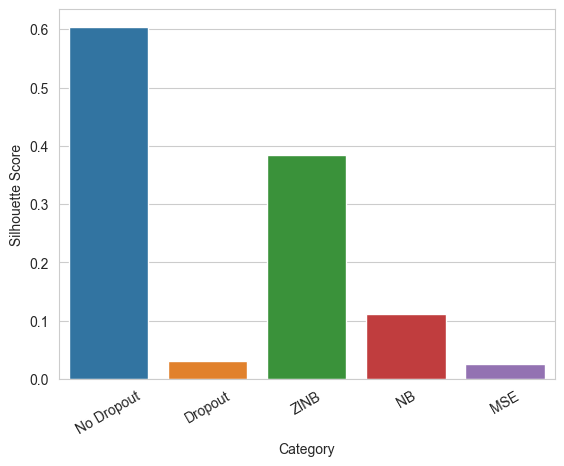

In [36]:
df
plt.xticks(rotation=30)
sns.barplot(data=df, x="Category", y="Silhouette Score")